In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn import linear_model

sns.set(rc={"figure.figsize": (13, 10)})

import gc
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [2]:
train_data = pd.read_csv("./data/train.csv").set_index("id")
valid_data = pd.read_csv("./data/test.csv").set_index("id")
datasets = [train_data, valid_data]
train_data.shape, valid_data.shape


((26570, 25), (20775, 24))

In [3]:
train_data.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


# define constants

In [4]:
TARGET = "failure"
SEED = 0

# Encode categorical data

In [5]:
# load csv and set id column as index

# lable encode categorical columns
cat_cols = ['product_code', 'attribute_0', 'attribute_1']

for data in datasets:
    for col in cat_cols:
        data[col] = data[col].astype('category').cat.codes

train_data.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,0,80.10,1,2,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,0,84.89,1,2,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,0,82.43,1,2,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,0,101.07,1,2,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,0,188.06,1,2,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


# Fill None values by median

In [6]:
print("NAs in adild data: ", valid_data.isna().sum().sum(), "\n")
train_data.isna().sum()

NAs in adild data:  15709 



product_code         0
loading            250
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      381
measurement_4      538
measurement_5      676
measurement_6      796
measurement_7      937
measurement_8     1048
measurement_9     1227
measurement_10    1300
measurement_11    1468
measurement_12    1601
measurement_13    1774
measurement_14    1874
measurement_15    2009
measurement_16    2110
measurement_17    2284
failure              0
dtype: int64

In [7]:
for data in datasets:
    for col in data.filter(regex="measurement_").columns.tolist():
        data[col] = data.groupby(["product_code", "attribute_0", "attribute_1"])[col].transform(lambda x: x.fillna(x.median()))
        
    data['loading'] = data.groupby("product_code")["loading"].transform(lambda x: x.fillna(x.median()))

print(f"Train NAs: {train_data.isna().sum().sum()}\nTest NAs: {valid_data.isna().sum().sum()}")

Train NAs: 0
Test NAs: 0


# Data Analysis

## Create copy of our data for analysis

In [8]:
train_copy = train_data.copy(deep=True)
valid_copy = valid_data.copy(deep=True)
train_copy["origin"] = "train"
valid_copy["origin"] = "valid"
valid_copy[TARGET] = -1

train_val_copy = pd.concat([train_copy, valid_copy], axis=0)

del train_copy, valid_copy
gc.collect()

0

In [9]:
train_val_copy.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,origin
id,,,,,,,,,,,,,,,,,,,,,
0,0,80.10,1,2,9,5,7,8,4,18.040,...,15.859,17.594,15.193,15.029,16.0265,13.034,14.684,764.100,0,train
1,0,84.89,1,2,9,5,14,3,3,18.213,...,17.947,17.915,11.755,14.732,15.4250,14.395,15.631,682.057,0,train
2,0,82.43,1,2,9,5,12,1,5,18.057,...,15.607,19.460,13.798,16.711,18.6310,14.094,17.946,663.376,0,train
3,0,101.07,1,2,9,5,13,2,6,17.295,...,16.346,18.377,10.020,15.250,15.5620,16.154,17.172,826.282,0,train
4,0,188.06,1,2,9,5,9,2,8,19.346,...,17.082,19.932,12.428,16.182,12.7600,13.153,16.412,579.885,0,train


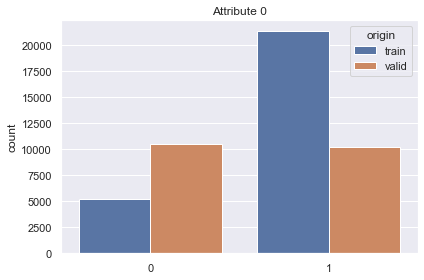

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.countplot(data=train_val_copy, x='attribute_0', hue='origin', ax=ax)
ax.set_title('Attribute 0')
ax.set_xlabel('')
plt.tight_layout()
plt.show()

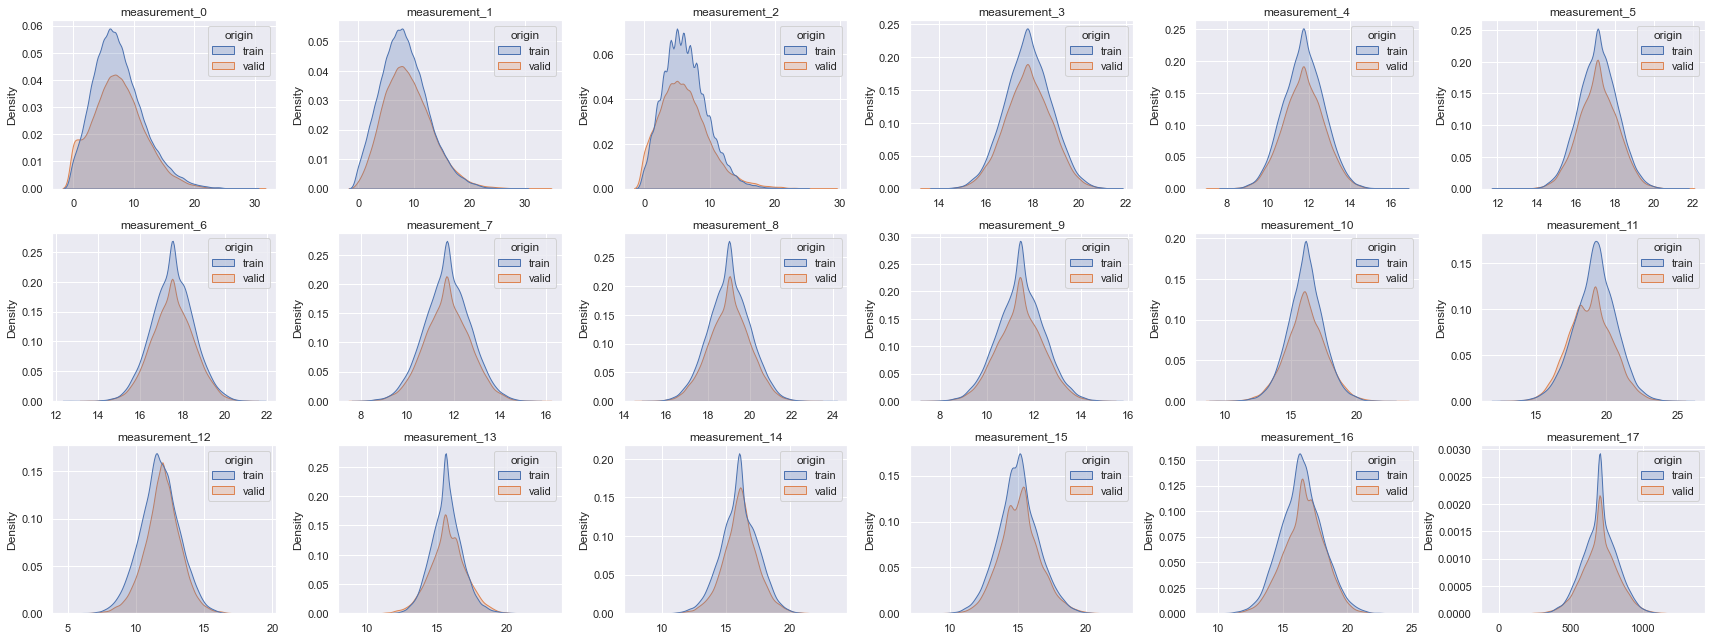

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(24, 9))
ax = ax.flatten()

for i, col in enumerate(train_val_copy.filter(regex='measurement_').columns.tolist()):
    sns.kdeplot(data=train_val_copy, x=col, hue='origin', fill=True, ax=ax[i])
    ax[i].set_title(col)
    ax[i].set_xlabel('')
    
plt.tight_layout()
plt.show()

In [12]:
ks_test = pd.DataFrame()
for col in train_val_copy.filter(regex='measurement_').columns.tolist():
    statistic, pvalue = sp.stats.kstest(train_val_copy[train_val_copy.origin == 'train'][col], train_val_copy[train_val_copy.origin == 'valid'][col])
    ks_test = ks_test.append(pd.DataFrame(data=pvalue, columns=['p_value'], index=[col]))

print(ks_test.round(2))

                p_value
measurement_0      0.00
measurement_1      0.00
measurement_2      0.00
measurement_3      0.77
measurement_4      0.09
measurement_5      0.22
measurement_6      0.11
measurement_7      0.00
measurement_8      0.00
measurement_9      0.00
measurement_10     0.00
measurement_11     0.00
measurement_12     0.00
measurement_13     0.00
measurement_14     0.00
measurement_15     0.00
measurement_16     0.00
measurement_17     0.00


In [13]:
residual_measurements = [f"measurement_{i}" for i in range(0, 3)] + [f"measurement_{i}" for i in range(10, 17)]
residual_measurements

['measurement_0',
 'measurement_1',
 'measurement_2',
 'measurement_10',
 'measurement_11',
 'measurement_12',
 'measurement_13',
 'measurement_14',
 'measurement_15',
 'measurement_16']

# Data cleanin

In [14]:
# for data in datasets:
#     data.drop(columns=residual_measurements, inplace=True)
# valid_data.head()

# Create model

## Train, test split

In [15]:
train_data[TARGET] = train_data[TARGET].astype(float)
# valid_data[TARGET] = valid_data[TARGET].astype(float)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26570 entries, 0 to 26569
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_code    26570 non-null  int8   
 1   loading         26570 non-null  float64
 2   attribute_0     26570 non-null  int8   
 3   attribute_1     26570 non-null  int8   
 4   attribute_2     26570 non-null  int64  
 5   attribute_3     26570 non-null  int64  
 6   measurement_0   26570 non-null  int64  
 7   measurement_1   26570 non-null  int64  
 8   measurement_2   26570 non-null  int64  
 9   measurement_3   26570 non-null  float64
 10  measurement_4   26570 non-null  float64
 11  measurement_5   26570 non-null  float64
 12  measurement_6   26570 non-null  float64
 13  measurement_7   26570 non-null  float64
 14  measurement_8   26570 non-null  float64
 15  measurement_9   26570 non-null  float64
 16  measurement_10  26570 non-null  float64
 17  measurement_11  26570 non-null 

In [16]:
X = train_data.drop(columns=TARGET)
y = train_data[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [17]:
params = {
    "penalty": ["l1", "l2", "elasticnet", "none"],
    # "class_weight": [{1 : 3, 0: 1}, {1 : 2, 0: 1}, {1 : 1, 0: 1}],
    "solver": ["newton-cg", "lbfgs", "lbfgs", "sag", "saga"]
}

In [18]:
log_reg = LogisticRegression()

gscv = GridSearchCV(log_reg, param_grid=params, cv=5)
gscv.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'lbfgs', 'sag',
                                    'saga']})

In [19]:

best_solution = gscv.best_estimator_
best_solution.score(X_test, y_test)

0.7835315369561945

In [20]:
best_solution.get_params

<bound method BaseEstimator.get_params of LogisticRegression(penalty='l1', solver='saga')>

In [21]:
solution = best_solution.predict(valid_data)
submission = pd.read_csv("./data/sample_submission.csv")
submission[TARGET] = solution
submission.head()

,id,failure
0,26570,0.0
1,26571,0.0
2,26572,0.0
3,26573,0.0
4,26574,0.0


In [22]:
submission[["id", TARGET]].to_csv("./data/solution.csv", index=False)